In [1]:
from fastai.vision.all import *

In [2]:
paintings = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    get_items=get_image_files,
                    splitter=RandomSplitter(valid_pct=0.2, seed=42),
                    get_y=parent_label,
                    item_tfms=RandomResizedCrop(244, min_scale=0.3),
                    batch_tfms=aug_transforms())

In [3]:
dls= paintings.dataloaders('resources/cleaned', num_workers=0)

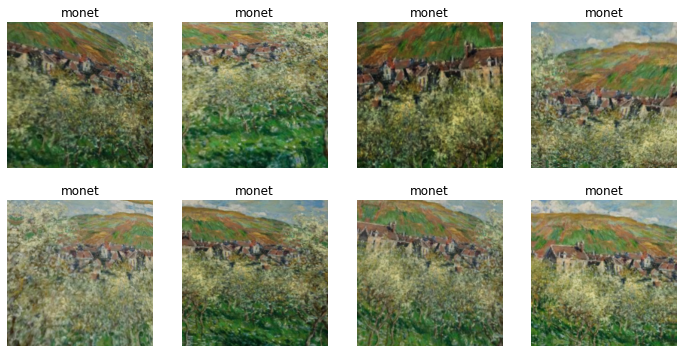

In [4]:
dls.train.show_batch(max_n=8,nrows=2,unique=True)

In [5]:
learn_34 = cnn_learner(dls, resnet34, metrics=accuracy)

In [6]:
learn_34.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,2.333042,1.100134,0.636719,00:35


epoch,train_loss,valid_loss,accuracy,time
0,1.420514,0.864058,0.738281,00:12
1,1.180355,0.709304,0.781250,00:11
2,0.956904,0.790155,0.789062,00:11
3,0.787079,0.699864,0.800781,00:11
4,0.682871,0.673947,0.796875,00:11


In [7]:
learn_34.save('test')

Path('models/test.pth')

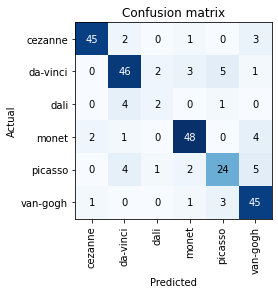

In [35]:
interp = ClassificationInterpretation.from_learner(learn_34)
interp.plot_confusion_matrix()

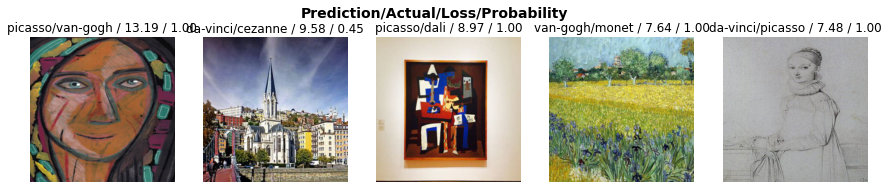

In [36]:
interp.plot_top_losses(5, nrows=1)

In [28]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn_34)
cleaner

In [29]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [37]:
learn_34.export(fname='firstmodel.pkl')

## Weighted classes

To overcome inbalanced dataset we can use weighted classes. With this approach we give our lossfunction predetermined weights we calculated. 

In Fastai this is easily done since you can set your own loss function.

In [36]:
import os
import torch

In [8]:
images = get_image_files('resources/cleaned')

In [10]:
#Calculate weights
def get_weight_of_painters(base_dir='resources/cleaned'):
    #get painter counts
    painter_counts = []
    for i in range(len(os.listdir(path=base_dir))):
        painter = os.listdir(path=base_dir)[i]
        painter_count = len(os.listdir(path=f'{base_dir}/{painter}'))
        painter_counts.append(painter_count)
    
    #calculate weights
    total = sum(painter_counts)
        
    weights = [total/(2.0*w) for w in painter_counts]
    return weights

In [11]:
class_weights = torch.Tensor(get_weight_of_painters()).cuda()
class_weights

tensor([2.9043, 2.7377, 2.2267, 3.7111, 6.6800, 2.3688], device='cuda:0')

In [12]:
loss_func = CrossEntropyLossFlat(weight=class_weights)

In [7]:
learn_34_weighted = cnn_learner(dls, resnet34, loss_func=loss_func, metrics=accuracy)

In [8]:
learn_34_weighted.fit_one_cycle(15)

epoch,train_loss,valid_loss,accuracy,time
0,2.867651,2.056329,0.277154,00:12
1,2.470317,1.457490,0.490637,00:10
2,2.045577,1.188349,0.580524,00:10
3,1.701395,1.102742,0.659176,00:10
4,1.477011,1.097888,0.685393,00:10
5,1.284574,1.029163,0.692884,00:10
6,1.151544,0.986683,0.707865,00:10
7,1.009029,1.031588,0.741573,00:10
8,0.914885,0.984768,0.764045,00:10
9,0.815438,0.960413,0.764045,00:11


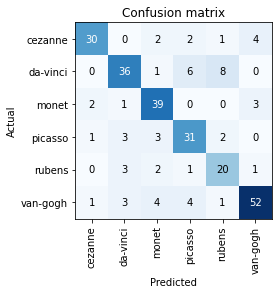

In [9]:
interp = ClassificationInterpretation.from_learner(learn_34_weighted)
interp.plot_confusion_matrix()

In [5]:
dls_smallbatch= paintings.dataloaders('resources/cleaned', num_workers=0, bs=32)

In [13]:
learn_50_weighted = cnn_learner(dls_smallbatch, resnet50, loss_func=loss_func, metrics=accuracy)

In [14]:
learn_50_weighted.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,2.252644,1.399374,0.528090,00:20
1,1.692478,1.319234,0.606742,00:17
2,1.406883,1.272538,0.674157,00:17
3,1.118674,1.059039,0.722846,00:17
4,0.890027,1.013347,0.726592,00:17
5,0.730505,0.910503,0.749064,00:17
6,0.638093,0.933331,0.745318,00:17
7,0.558741,0.881707,0.749064,00:17
8,0.495771,0.878501,0.760300,00:17
9,0.450880,0.875877,0.749064,00:17


In [15]:
learn_50_weighted.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.402780,0.909075,0.734082,00:17
1,0.405065,0.891036,0.767790,00:17


SuggestedLRs(lr_min=6.30957365501672e-06, lr_steep=5.754399353463668e-06)

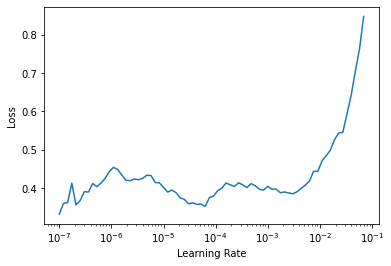

In [16]:
learn_50_weighted.lr_find()

In [17]:
learn_50_weighted.fit_one_cycle(2, 10e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.427855,1.068954,0.760300,00:17
1,0.400023,0.993291,0.767790,00:17


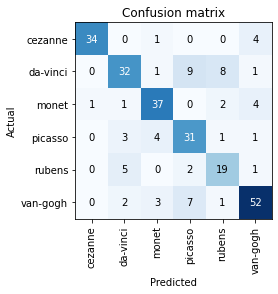

In [18]:
interp = ClassificationInterpretation.from_learner(learn_50_weighted)
interp.plot_confusion_matrix()

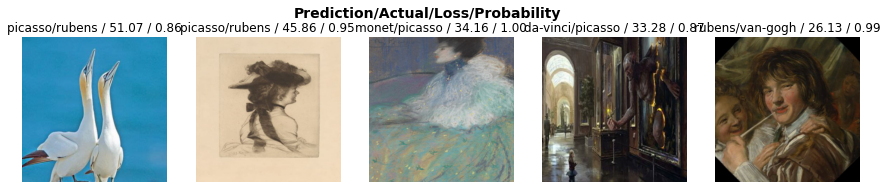

In [19]:
interp.plot_top_losses(5, nrows=1)